- Data from: https://github.com/shahar603/Telemetry-Data/tree/master/SpaceX%20CRS-10

# Imports

In [110]:
import sqlite3
import pandas as pd
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats

In [111]:
input_files = sorted((Path("..") / "data").glob("*.xlsx"))
raw_input_file = input_files[0]
analysed_input_file = input_files[1]
events_file = input_files[2]
input_files

[PosixPath('../data/SpaceX CRS-10 raw.xlsx'),
 PosixPath('../data/analysed.xlsx'),
 PosixPath('../data/events.xlsx'),
 PosixPath('../data/stage2 raw.xlsx')]

In [112]:
with pd.ExcelFile(raw_input_file) as crs_file:
    sheet_names = crs_file.sheet_names
    crs_10_df = pd.read_excel(crs_file, sheet_name=sheet_names[0])

In [113]:
with pd.ExcelFile(analysed_input_file) as crs_file:
    sheet_names = crs_file.sheet_names
    crs_10_analysed_df = pd.read_excel(crs_file, sheet_name=sheet_names[0])

In [114]:
with pd.ExcelFile(events_file) as events_file:
    events_df = pd.read_excel(events_file, sheet_name=events_file.sheet_names[0], header=0)

In [115]:
crs_10_df.head()

,time,velocity,altitude
0,0.000,0.000,0.0
1,0.033,0.555,0.0
2,0.066,0.555,0.0
3,0.100,0.555,0.0
4,0.133,0.555,0.0


In [116]:
events_df_clean = (events_df
 .dropna(subset='Time [s]')
 .sort_values("Time [s]")
)

events_df_clean

,Event,Time [s]
13,throttle_down_start,50.0
14,throttle_down_end,66.0
3,maxq,75.0
6,meco,143.0
10,ses1,154.0


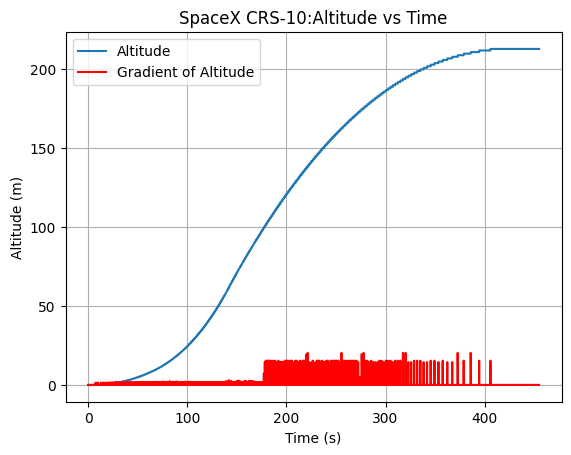

In [117]:
crs_10_df['gradient_of_altitude'] = np.gradient(crs_10_df["altitude"], crs_10_df["time"])

plt.plot(crs_10_df["time"], crs_10_df["altitude"], label="Altitude")
plt.plot(crs_10_df["time"], crs_10_df["gradient_of_altitude"], c="r", label="Gradient of Altitude")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.title("SpaceX CRS-10:Altitude vs Time")
plt.legend()
plt.grid()  
plt.show();

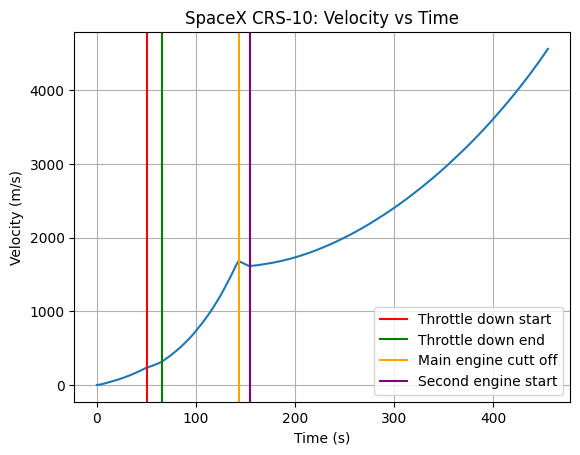

In [118]:
plt.plot(crs_10_df["time"], crs_10_df["velocity"])
plt.axvline(x=50, label="Throttle down start", c='r')
plt.axvline(x=66, label="Throttle down end", c='g')
plt.axvline(x=143, label="Main engine cutt off", c='orange')
plt.axvline(x=154, label="Second engine start", c='purple')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("SpaceX CRS-10: Velocity vs Time")
plt.legend()
plt.grid();

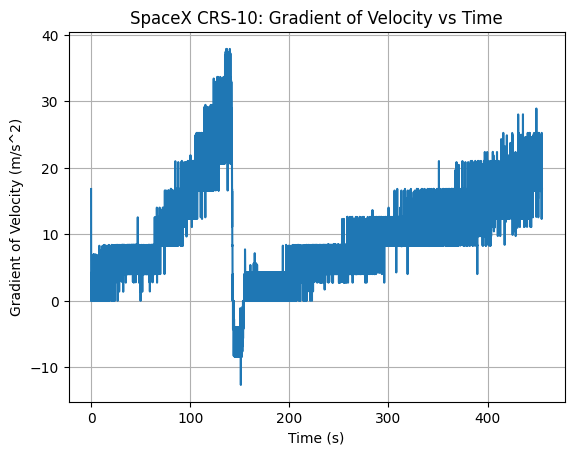

In [119]:
crs_10_df['gradient_of_velocity'] = np.gradient(crs_10_df["velocity"], crs_10_df["time"])

plt.plot(crs_10_df["time"], crs_10_df["gradient_of_velocity"])
plt.xlabel("Time (s)")
plt.ylabel("Gradient of Velocity (m/s^2)")
plt.title("SpaceX CRS-10: Gradient of Velocity vs Time")
plt.grid();

# Z-score outliers

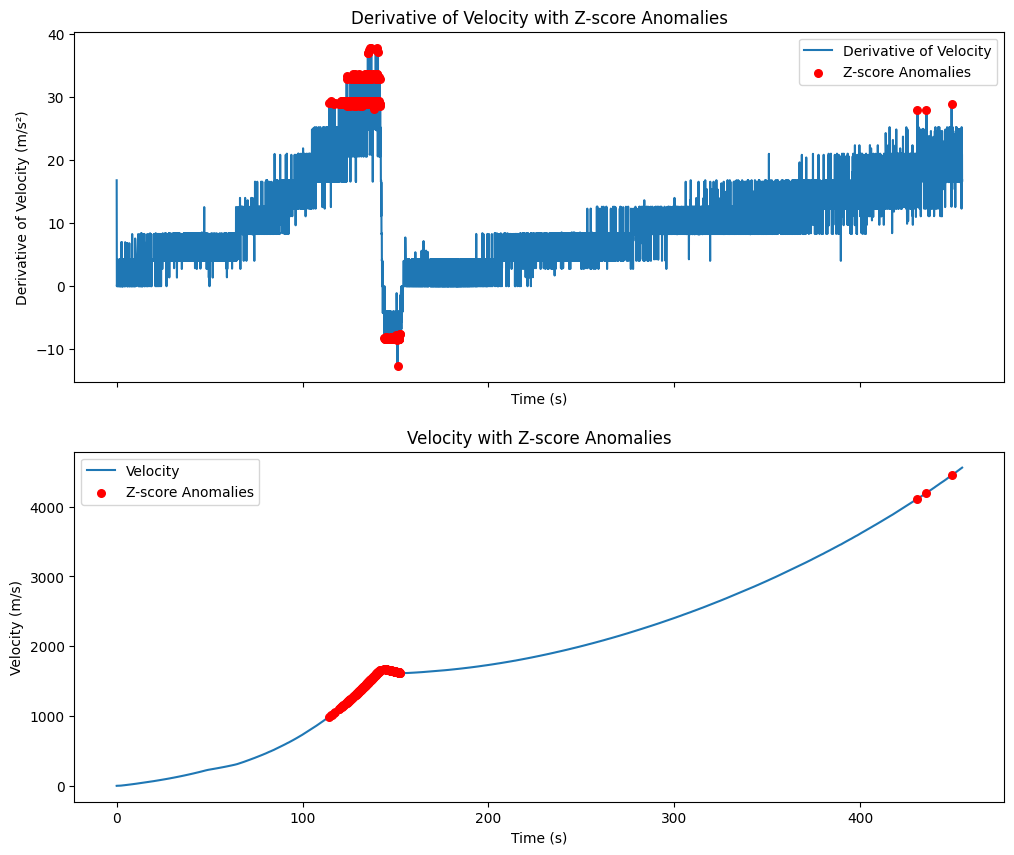

In [120]:
z_scores = np.abs(stats.zscore(crs_10_df["gradient_of_velocity"]))
threshold_zscore = 2.5
anomalies_zscore = z_scores > threshold_zscore

time_anomalies_z_score = crs_10_df.loc[anomalies_zscore, "time"]
gradient_anomalies_z_score = crs_10_df.loc[anomalies_zscore, "gradient_of_velocity"]
velo_anomalies_z_score = crs_10_df.loc[anomalies_zscore, "velocity"]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
ax1.plot(crs_10_df['time'],
         crs_10_df['gradient_of_velocity'],
         label="Derivative of Velocity"
         )
ax1.scatter(x=time_anomalies_z_score,
            y=gradient_anomalies_z_score,
            color='red', 
            s=30,
            zorder=5, 
            label='Z-score Anomalies')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Derivative of Velocity (m/s²)")
ax1.set_title("Derivative of Velocity with Z-score Anomalies")
ax1.legend();

ax2.plot(crs_10_df['time'],
         crs_10_df['velocity'],
         label="Velocity"
         )
ax2.scatter(x=time_anomalies_z_score,
            y=velo_anomalies_z_score,
            color='red', 
            s=30,
            zorder=5, 
            label='Z-score Anomalies')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Velocity (m/s)")
ax2.set_title("Velocity with Z-score Anomalies")
ax2.legend();

# IQR Outliers

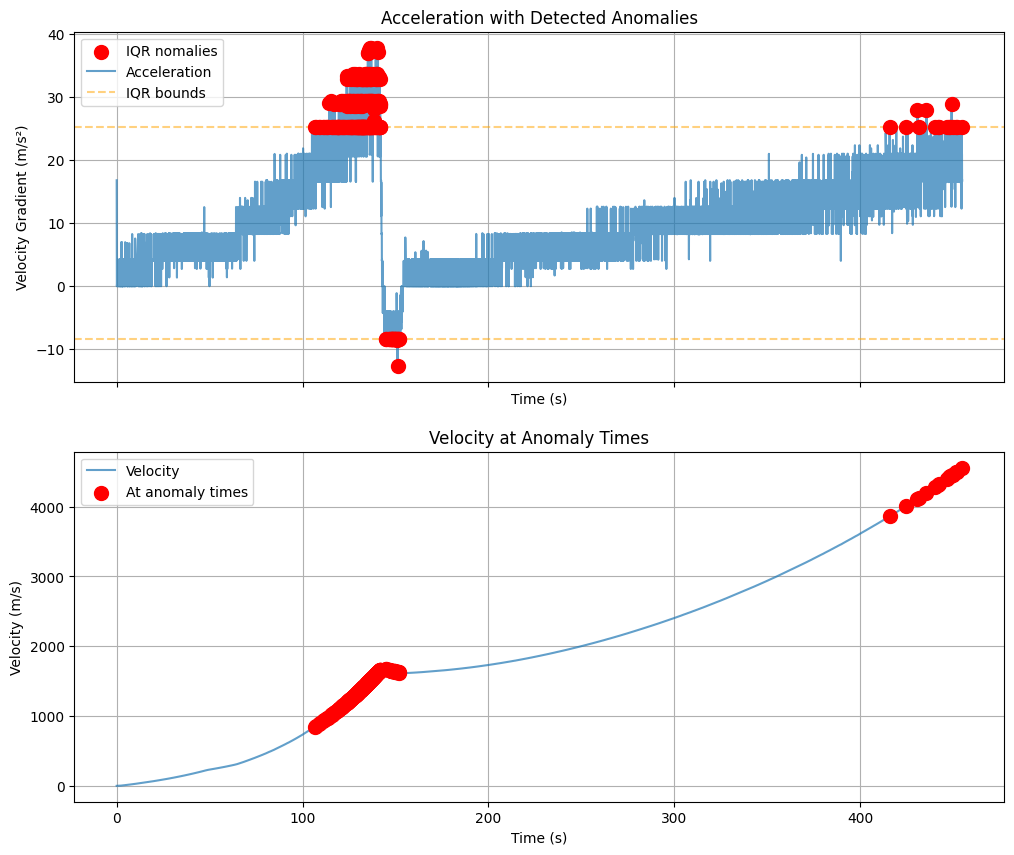

In [121]:
Q1 = crs_10_df["gradient_of_velocity"].quantile(0.25)
Q3 = crs_10_df["gradient_of_velocity"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
iqr_anomalies = (crs_10_df["gradient_of_velocity"] < lower_bound) | (crs_10_df["gradient_of_velocity"] > upper_bound)

time_anomalies_iqr = crs_10_df.loc[iqr_anomalies, "time"]
gradient_anomalies_iqr = crs_10_df.loc[iqr_anomalies, "gradient_of_velocity"]
velo_anomalies_iqr = crs_10_df.loc[iqr_anomalies, "velocity"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
ax1.scatter(time_anomalies_iqr, 
            gradient_anomalies_iqr, 
            color='red', 
            s=100, 
            label='IQR nomalies', 
            zorder=5)
ax1.plot(crs_10_df["time"], 
         crs_10_df["gradient_of_velocity"], 
         label="Acceleration", 
         alpha=0.7)
ax1.axhline(y=upper_bound, 
            color='orange', 
            linestyle='--', 
            alpha=0.5, 
            label='IQR bounds')
ax1.axhline(y=lower_bound, 
            color='orange', 
            linestyle='--', 
            alpha=0.5)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Velocity Gradient (m/s²)")
ax1.set_title("Acceleration with Detected Anomalies")
ax1.legend()
ax1.grid()

ax2.plot(crs_10_df["time"], 
         crs_10_df["velocity"], 
         label="Velocity", 
         alpha=0.7)
ax2.scatter(time_anomalies_iqr, 
            velo_anomalies_iqr, 
            color='red', 
            s=100, 
            label='At anomaly times', 
            zorder=5)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Velocity (m/s)")
ax2.set_title("Velocity at Anomaly Times")
ax2.legend()
ax2.grid();


# Analysed File

In [122]:
crs_10_analysed_df.head()

,time,velocity,altitude,velocity_y,velocity_x,acceleration,downrange_distance,angle,q
0,0,0.000,0.000,0.000,0.0,10.577,0.0,90.0,0.000000
1,1,1.628,0.001,2.003,0.0,11.036,0.0,90.0,1.623722
2,2,2.820,0.003,3.923,0.0,11.522,0.0,90.0,4.869602
3,3,5.455,0.007,6.081,0.0,12.100,0.0,90.0,18.212593
4,4,8.271,0.014,8.709,0.0,12.581,0.0,90.0,41.847315


In [123]:
crs_10_analysed_df.columns

Index(['time', 'velocity', 'altitude', 'velocity_y', 'velocity_x',
       'acceleration', 'downrange_distance', 'angle', 'q'],
      dtype='object')

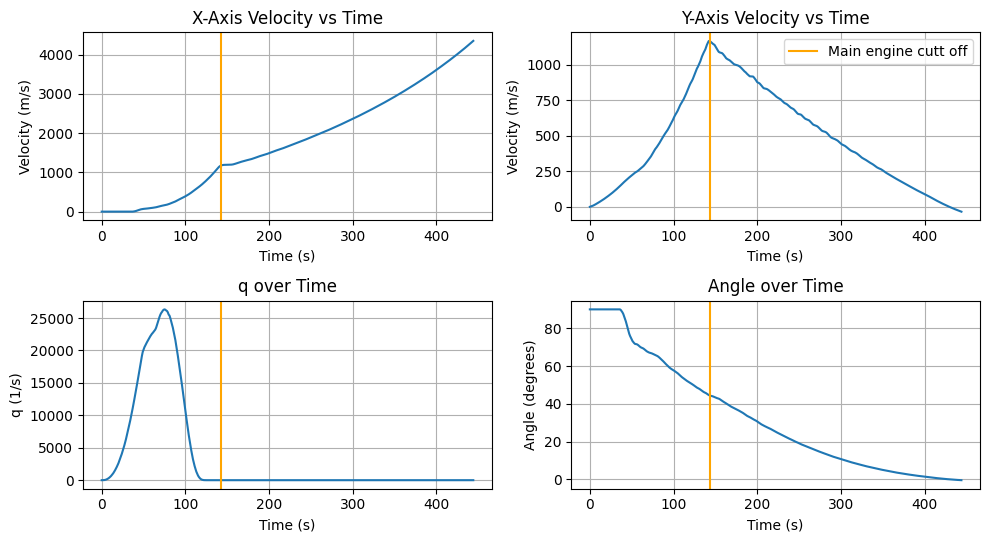

In [124]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

axs[0, 0].plot(crs_10_analysed_df["time"], 
         crs_10_analysed_df["velocity_x"])
axs[0, 0].axvline(x=143, label="Main engine cutt off", c='orange')
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_ylabel("Velocity (m/s)")
axs[0, 0].set_title("X-Axis Velocity vs Time")
axs[0, 0].grid()

axs[0, 1].plot(crs_10_analysed_df["time"], 
         crs_10_analysed_df["velocity_y"])
axs[0, 1].axvline(x=143, label="Main engine cutt off", c='orange')
axs[0, 1].set_xlabel("Time (s)")
axs[0, 1].set_ylabel("Velocity (m/s)")
axs[0, 1].set_title("Y-Axis Velocity vs Time")
axs[0, 1].legend()
axs[0, 1].grid()


axs[1, 0].plot(crs_10_analysed_df["time"],    
         crs_10_analysed_df["q"])
axs[1, 0].axvline(x=143, label="Main engine cutt off", c='orange')
axs[1, 0].grid()
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_ylabel("q (1/s)")
axs[1, 0].set_title("q over Time")

axs[1, 1].plot(crs_10_analysed_df["time"], 
         crs_10_analysed_df["angle"])
axs[1, 1].axvline(x=143, label="Main engine cutt off", c='orange')
axs[1, 1].grid()
axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_ylabel("Angle (degrees)")
axs[1, 1].set_title("Angle over Time")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show();

## Question: When does the rocket exit the atmostphere?

In [125]:
q_at_0 = (crs_10_analysed_df
          .query("time > 0 and q <= 0")
          .loc[:, ["time", "q"]]
          .iloc[0]
          ["time"]
        )
print(f"q hits 0 at time: {q_at_0} seconds, which is when the rocket has exited the atmosphere.")

q hits 0 at time: 126.0 seconds, which is when the rocket has exited the atmosphere.


- **q**: It appears that based on the q (dynamic pressure) that the rocket exits the atmosphere at t = 126 seconds
- Now knowing the true acceleration, as opposed to calculating the gradient of the velocity, I will again use a Z test to find any anomalies in the acceleration that switching from the main engine to the back-up may have caused

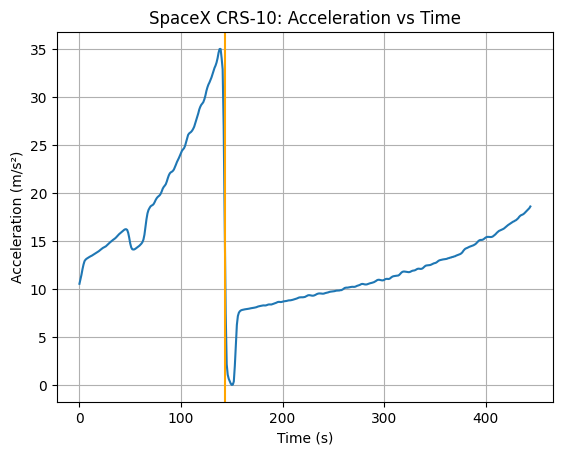

In [126]:
plt.plot(crs_10_analysed_df["time"], 
         crs_10_analysed_df["acceleration"])
plt.axvline(x=143, label="Main engine cutt off", c='orange')
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("SpaceX CRS-10: Acceleration vs Time")
plt.grid()
plt.show();

In [127]:
z_scores = np.abs(stats.zscore(crs_10_analysed_df["acceleration"]))
threshold_zscore = 2
anomalies_zscore = z_scores > threshold_zscore

time_anomalies_z_score = crs_10_analysed_df.loc[anomalies_zscore, "time"]
accel_anomalies_z_score = crs_10_analysed_df.loc[anomalies_zscore, "acceleration"]
velo_x_anomalies_z_score = crs_10_analysed_df.loc[anomalies_zscore, "velocity_x"]

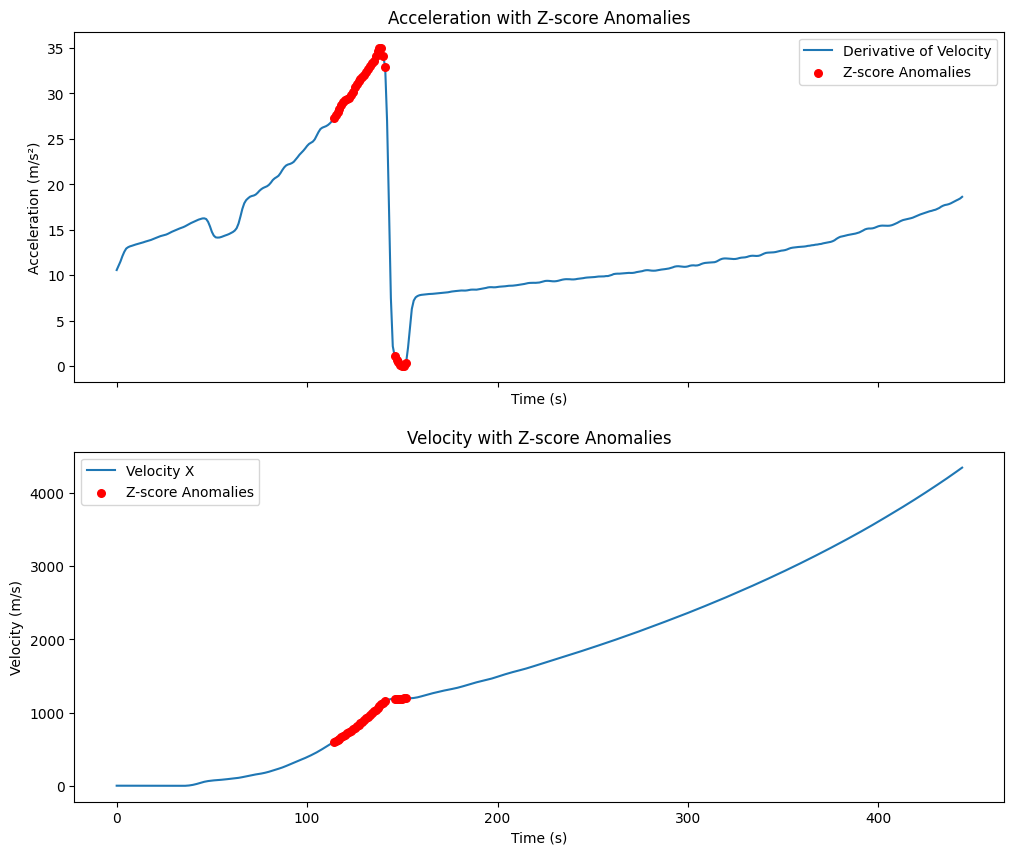

In [128]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
ax1.plot(crs_10_analysed_df['time'],
         crs_10_analysed_df['acceleration'],
         label="Derivative of Velocity"
         )
ax1.scatter(x=time_anomalies_z_score,
            y=accel_anomalies_z_score,
            color='red', 
            s=30,
            zorder=5, 
            label='Z-score Anomalies')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s²)")
ax1.set_title("Acceleration with Z-score Anomalies")
ax1.legend();

ax2.plot(crs_10_analysed_df['time'],
         crs_10_analysed_df['velocity_x'],
         label="Velocity X"
         )
ax2.scatter(x=time_anomalies_z_score,
            y=velo_x_anomalies_z_score,
            color='red', 
            s=30,
            zorder=5, 
            label='Z-score Anomalies')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Velocity (m/s)")
ax2.set_title("Velocity with Z-score Anomalies")
ax2.legend();

# Rolling Z-score

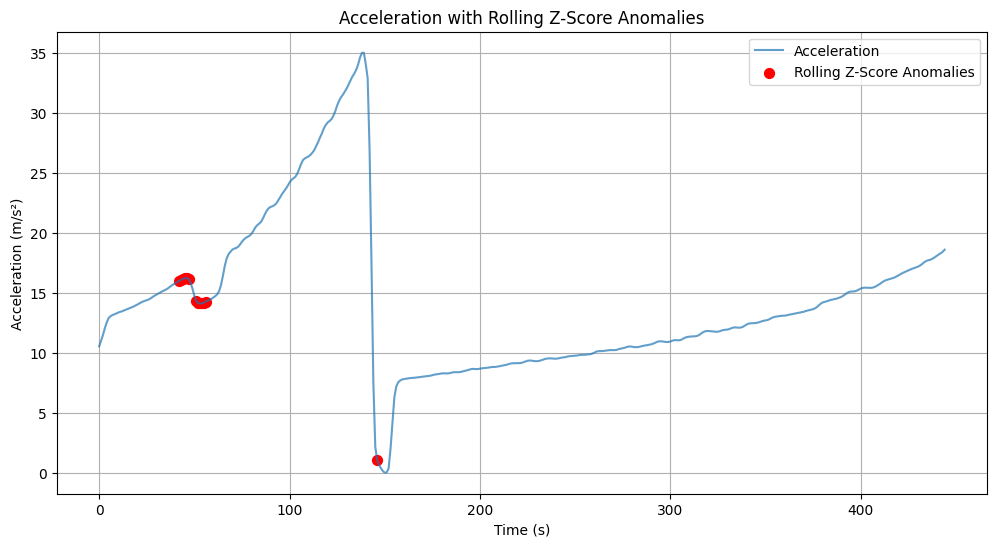

In [129]:
def rolling_zscore(series, window=50):
    rolling_mean = series.rolling(window=window, center=True).mean()
    rolling_std = series.rolling(window=window, center=True).std()
    z_scores = np.abs((series - rolling_mean) / rolling_std)
    return z_scores

rolling_z = rolling_zscore(crs_10_analysed_df["acceleration"], window=30)
rolling_anomalies = rolling_z > 1

plt.figure(figsize=(12, 6))
plt.plot(crs_10_analysed_df["time"], crs_10_analysed_df["acceleration"], label="Acceleration", alpha=0.7)
plt.scatter(crs_10_analysed_df.loc[rolling_anomalies, "time"], 
            crs_10_analysed_df.loc[rolling_anomalies, "acceleration"],
            color='red', 
            s=50, 
            label='Rolling Z-Score Anomalies')
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Acceleration with Rolling Z-Score Anomalies")
plt.legend()
plt.grid()
plt.show()

# SQL Analysis Section

In [130]:
conn = sqlite3.connect(':memory:')

crs_10_analysed_df.to_sql('telemetry', conn, index=False, if_exists='replace')

cursor = conn.cursor()
cursor.execute(
"""
SELECT name 
FROM sqlite_master 
WHERE type='table';
"""
)
tables = cursor.fetchall()
print("Tables:", tables)

Tables: [('telemetry',)]


In [131]:
query1 = """
SELECT 
    COUNT(*) as total_records,
    ROUND(MIN(velocity), 2) as min_velocity,
    ROUND(MAX(velocity), 2) as max_velocity,
    ROUND(AVG(velocity), 2) as avg_velocity
FROM telemetry
"""

result1 = pd.read_sql_query(query1, conn)
print("Velocity Statistics:")
print(result1)
print()

Velocity Statistics:
   total_records  min_velocity  max_velocity  avg_velocity
0            445           0.0        4348.8       1902.11



In [132]:
query2 = """
SELECT 
    time,
    velocity,
    altitude,
    acceleration,
    q
FROM telemetry
WHERE velocity > 2500
ORDER BY time
LIMIT 10
"""

result2 = pd.read_sql_query(query2, conn)
print("Records with high velocity (>5000 m/s):")
result2

Records with high velocity (>5000 m/s):


,time,velocity,altitude,acceleration,q
0,310,2500.473,190.577,11.381,0.0
1,311,2510.187,190.974,11.397,0.0
2,312,2520.179,191.365,11.408,0.0
3,313,2530.169,191.755,11.413,0.0
4,314,2540.604,192.145,11.441,0.0
5,315,2550.155,192.533,11.512,0.0
6,316,2560.147,192.920,11.626,0.0
7,317,2570.972,193.303,11.740,0.0
8,318,2581.241,193.683,11.817,0.0
9,319,2591.789,194.059,11.851,0.0


In [133]:
query3 = """
SELECT 
    time,
    velocity,
    altitude,
    CASE 
        WHEN altitude < 75 THEN 'Low Altitude'
        WHEN altitude < 110 THEN 'Mid Altitude'
        WHEN altitude < 180 THEN 'Upper Atmosphere'
        ELSE 'Space'
    END as flight_phase,
    CASE 
        WHEN velocity < 500 THEN 'Low Speed'
        WHEN velocity < 2000 THEN 'Medium Speed'
        WHEN velocity < 5000 THEN 'High Speed'
        ELSE 'Orbital Speed'
    END as velocity_phase
FROM telemetry
WHERE time % 10 = 0  -- Sample every 10 seconds for readability
ORDER BY time
"""

result3 = pd.read_sql_query(query3, conn)
print("Flight phase classification:")
print(result3)
print()

Flight phase classification:
    time  velocity  altitude      flight_phase velocity_phase
0      0     0.000     0.000      Low Altitude      Low Speed
1     10    28.570     0.124      Low Altitude      Low Speed
2     20    67.417     0.599      Low Altitude      Low Speed
3     30   114.183     1.500      Low Altitude      Low Speed
4     40   169.556     2.909      Low Altitude      Low Speed
5     50   232.570     4.882      Low Altitude      Low Speed
6     60   282.251     7.343      Low Altitude      Low Speed
7     70   358.586    10.316      Low Altitude      Low Speed
8     80   462.112    14.131      Low Altitude      Low Speed
9     90   586.750    18.856      Low Altitude   Medium Speed
10   100   733.611    24.530      Low Altitude   Medium Speed
11   110   908.169    31.394      Low Altitude   Medium Speed
12   120  1109.231    39.410      Low Altitude   Medium Speed
13   130  1343.186    48.787      Low Altitude   Medium Speed
14   140  1611.742    59.491      Low Alt

In [134]:
query4 = """
SELECT 
    CASE 
        WHEN altitude < 143 THEN 'Phase 1: Main Engine'
        WHEN altitude < 200 THEN 'Phase 2: Mid-flight'
        WHEN altitude < 100000 THEN 'Phase 3: Upper Atm'
        ELSE 'Phase 4: Space'
    END as flight_phase,
    COUNT(*) as record_count,
    ROUND(AVG(velocity), 2) as avg_velocity,
    ROUND(AVG(acceleration), 2) as avg_acceleration,
    ROUND(MAX(q), 2) as max_q,
    ROUND(MIN(time), 0) as phase_start_time,
    ROUND(MAX(time), 0) as phase_end_time
FROM telemetry
GROUP BY flight_phase
ORDER BY phase_start_time
"""

result4 = pd.read_sql_query(query4, conn)
print("Aggregated statistics by flight phase:")
print(result4)
print()

Aggregated statistics by flight phase:
           flight_phase  record_count  avg_velocity  avg_acceleration  \
0  Phase 1: Main Engine           228        967.48             15.68   
1   Phase 2: Mid-flight           109       2269.85             10.64   
2    Phase 3: Upper Atm           108       3504.06             14.90   

      max_q  phase_start_time  phase_end_time  
0  26342.61               0.0           227.0  
1      0.00             228.0           336.0  
2      0.00             337.0           444.0  



In [135]:
query5 = """
WITH velocity_changes AS (
    SELECT 
        time,
        velocity,
        LAG(velocity) OVER (ORDER BY time) as prev_velocity,
        ROUND(velocity - LAG(velocity) OVER (ORDER BY time), 2) as velocity_change,
        ROUND(ABS(velocity - LAG(velocity) OVER (ORDER BY time)), 2) as abs_velocity_change
    FROM telemetry
    WHERE time > 0  -- Skip first record (has no prev value)
)
SELECT 
    time,
    velocity,
    velocity_change,
    abs_velocity_change
FROM velocity_changes
WHERE abs_velocity_change > 20
ORDER BY time
LIMIT 20
"""

result5 = pd.read_sql_query(query5, conn)
print("Significant velocity changes (anomaly detection pattern):")
print(result5)
print()

Significant velocity changes (anomaly detection pattern):
    time  velocity  velocity_change  abs_velocity_change
0    115  1004.354            20.42                20.42
1    116  1024.738            20.38                20.38
2    118  1066.356            21.77                21.77
3    119  1087.745            21.39                21.39
4    120  1109.231            21.49                21.49
5    121  1130.980            21.75                21.75
6    122  1153.349            22.37                22.37
7    123  1175.269            21.92                21.92
8    124  1197.631            22.36                22.36
9    125  1221.887            24.26                24.26
10   126  1245.473            23.59                23.59
11   127  1269.395            23.92                23.92
12   128  1294.035            24.64                24.64
13   129  1317.900            23.87                23.87
14   130  1343.186            25.29                25.29
15   131  1368.684            

In [136]:
query6 = """
SELECT 
    'System Health Report' as report_type,
    'CRS-10 Mission' as mission,
    (SELECT MAX(altitude) FROM telemetry) as max_altitude,
    (SELECT MAX(velocity) FROM telemetry) as achieved_velocity,
    (SELECT MAX(q) FROM telemetry) as peak_dynamic_pressure,
    (SELECT ROUND(MAX(time), 0) FROM telemetry) as mission_duration_seconds,
    COUNT(*) as total_telemetry_points,
    SUM(CASE WHEN acceleration > 0 THEN 1 ELSE 0 END) as time_in_pos_accel,
    SUM(CASE WHEN q > 0 THEN 1 ELSE 0 END) as time_in_atmosphere
FROM telemetry
"""

result6 = pd.read_sql_query(query6, conn)
print("Mission Health Summary (Weekly Report Style):")
print(result6)
print()

Mission Health Summary (Weekly Report Style):
            report_type         mission  max_altitude  achieved_velocity  \
0  System Health Report  CRS-10 Mission       213.277           4348.804   

   peak_dynamic_pressure  mission_duration_seconds  total_telemetry_points  \
0           26342.605549                     444.0                     445   

   time_in_pos_accel  time_in_atmosphere  
0                445                 125  



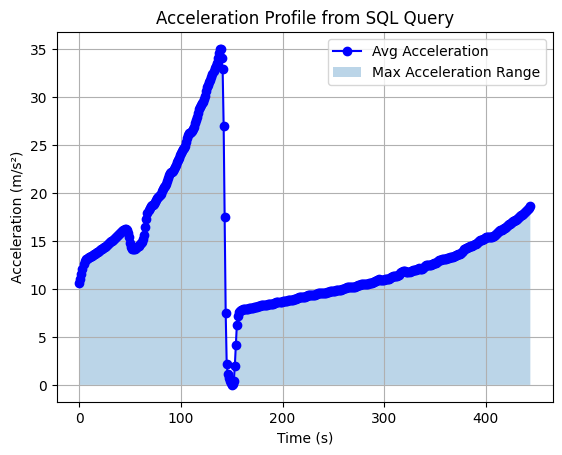

In [137]:
query_accel = """
SELECT 
    ROUND(time, 0) as time_bucket,
    ROUND(AVG(acceleration), 2) as avg_acceleration,
    ROUND(MAX(acceleration), 2) as max_acceleration,
    COUNT(*) as measurements
FROM telemetry
GROUP BY ROUND(time, 0)
ORDER BY time_bucket
"""

accel_by_time = pd.read_sql_query(query_accel, conn)

plt.plot(accel_by_time['time_bucket'], accel_by_time['avg_acceleration'], 
         marker='o', label='Avg Acceleration', color='blue')
plt.fill_between(accel_by_time['time_bucket'], 0, accel_by_time['max_acceleration'], 
                  alpha=0.3, label='Max Acceleration Range')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Acceleration Profile from SQL Query')
plt.legend()
plt.grid()
plt.show();